In [1]:
import torch
import pandas as pd
import astropy as ap
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
# from astropy.io import fits
import pdb
from scipy.ndimage.filters import maximum_filter1d
import glob
import fitsio as fits
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils
from torch.nn.utils import clip_grad_norm_
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence
from torch.distributions.normal import Normal
from tqdm import tqdm

In [2]:
import sys
sys.path.insert(0, '../')
sys.path.insert(1, '../latent_ode/')
import latent_ode.lib as ode
import latent_ode.lib.utils as utils
from latent_ode.lib.latent_ode import LatentODE
from latent_ode.lib.encoder_decoder import Encoder_z0_ODE_RNN, Decoder
from latent_ode.lib.diffeq_solver import DiffeqSolver
from latent_ode.lib.ode_func import ODEFunc

In [3]:
from latent_rnn import create_LatentODE_model

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

In [5]:
obsrv_std = torch.Tensor([0.01]).to(device)
z0_prior = Normal(torch.Tensor([0.0]).to(device), torch.Tensor([1.]).to(device))
input_dim = 1
model = create_LatentODE_model(input_dim, z0_prior, obsrv_std)

In [6]:
# state = torch.load('latent_ode_state.pth.tar')
state = torch.load('latent_ode_state.pth.tar', map_location=torch.device('cpu'))

In [7]:
model.load_state_dict(state['state_dict'])

<All keys matched successfully>

In [8]:
model.eval()

LatentODE(
  (encoder_z0): Encoder_z0_ODE_RNN(
    (GRU_update): GRU_unit(
      (update_gate): Sequential(
        (0): Linear(in_features=42, out_features=20, bias=True)
        (1): Tanh()
        (2): Linear(in_features=20, out_features=20, bias=True)
        (3): Sigmoid()
      )
      (reset_gate): Sequential(
        (0): Linear(in_features=42, out_features=20, bias=True)
        (1): Tanh()
        (2): Linear(in_features=20, out_features=20, bias=True)
        (3): Sigmoid()
      )
      (new_state_net): Sequential(
        (0): Linear(in_features=42, out_features=20, bias=True)
        (1): Tanh()
        (2): Linear(in_features=20, out_features=40, bias=True)
      )
    )
    (z0_diffeq_solver): DiffeqSolver(
      (ode_func): ODEFunc(
        (gradient_net): Sequential(
          (0): Linear(in_features=20, out_features=20, bias=True)
          (1): Tanh()
          (2): Linear(in_features=20, out_features=20, bias=True)
          (3): Tanh()
          (4): Linear(in_fea

In [9]:
loader = torch.load('toy_train.pt')

## Inference

In [10]:
def sample(z, t):
    sol_y = model.diffeq_solver.sample_traj_from_prior(z, t, n_traj_samples = 1)
    out = model.decoder(sol_y)
    return out

In [11]:
z_us = []
z_stds = []
truths = []
ts = []
recs = []
samples = []
for batch in tqdm(loader):
    observed = batch['observed_data']
    true = batch['data_to_predict']
    truths.extend([x for x in true])
    mask = batch['observed_mask']
    mask_pred = batch['mask_predicted_data']
#     mask_pred = torch.ones(mask.shape)
    x = torch.cat((observed, mask), -1)
    if not mask_pred:
        mask_pred = torch.ones(true.shape)
    x2 = torch.cat((true, mask_pred), -1)
    t = batch['observed_tp']
    truth_time_steps = t[mask.nonzero()]
    ts.append(t.detach().cpu())
    z_u, z_std = model.encoder_z0.forward(x, t)
    rec = model.get_reconstruction(time_steps_to_predict=t, truth=x2, truth_time_steps=t)[0].detach().cpu().squeeze()
    recs.extend([x for x in rec])
#     z_u = z_u.squeeze()
    s = sample(z_u, t)[0]
    samples.extend([x for x in s])
    z_u = z_u.detach().cpu()
    z_std = z_std.detach().cpu()
    z_us.append(z_u)
    z_stds.append(z_std)

100%|██████████| 18/18 [00:07<00:00,  2.39it/s]


In [12]:
rec

tensor([[ 0.0042, -0.0094, -0.0231, -0.0352, -0.0447, -0.0535, -0.0616, -0.0688,
         -0.0751, -0.0805, -0.0851, -0.0890, -0.0925, -0.0956, -0.0984, -0.1012,
         -0.1038, -0.1063, -0.1088, -0.1112, -0.1136, -0.1160, -0.1183, -0.1207,
         -0.1229, -0.1252, -0.1274, -0.1296, -0.1317, -0.1338, -0.1359, -0.1380,
         -0.1400, -0.1419, -0.1439, -0.1458, -0.1477, -0.1495, -0.1513, -0.1531,
         -0.1549, -0.1566, -0.1583, -0.1600, -0.1617, -0.1633, -0.1649, -0.1665,
         -0.1681],
        [ 0.4671,  0.4581,  0.4491,  0.4401,  0.4312,  0.4222,  0.4132,  0.4042,
          0.3952,  0.3861,  0.3768,  0.3674,  0.3577,  0.3479,  0.3381,  0.3283,
          0.3185,  0.3088,  0.2993,  0.2908,  0.2836,  0.2773,  0.2715,  0.2659,
          0.2604,  0.2550,  0.2496,  0.2443,  0.2392,  0.2341,  0.2295,  0.2257,
          0.2231,  0.2220,  0.2220,  0.2228,  0.2241,  0.2257,  0.2275,  0.2294,
          0.2313,  0.2334,  0.2355,  0.2377,  0.2399,  0.2420,  0.2442,  0.2467,
         

In [30]:
ix = 7

In [31]:
y = samples[ix].detach().cpu().numpy().reshape(1,-1)
# y = recs[ix].numpy().reshape(1,-1)
x = t.detach().cpu().numpy().reshape(1,-1)
y_true = truths[ix].detach().cpu().numpy().reshape(1,-1)

In [32]:
d_predict = np.concatenate([x, y], axis=0).T
d_true = np.concatenate([x, y_true], axis=0).T

In [33]:
df_predict = pd.DataFrame(d_predict, columns = ['t', 'value'])
df_predict['type'] = 'prediction'
df_truth = pd.DataFrame(d_true, columns = ['t', 'value'])
df_truth['type'] = 'truth'
df = pd.concat([df_predict, df_truth], 0)

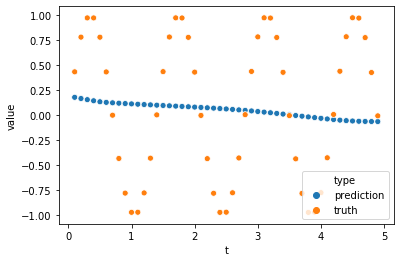

In [34]:
sns.scatterplot(x='t', y='value', data=df, hue='type')

In [25]:
true[0]

tensor([[ 0.4301],
        [ 0.7765],
        [ 0.9720],
        [ 0.9785],
        [ 0.7948],
        [ 0.4566],
        [ 0.0295],
        [-0.4032],
        [-0.7576],
        [-0.9647],
        [-0.9842],
        [-0.8124],
        [-0.4826],
        [-0.0590],
        [ 0.3760],
        [ 0.7380],
        [ 0.9565],
        [ 0.9890],
        [ 0.8293],
        [ 0.5083],
        [ 0.0885],
        [-0.3485],
        [-0.7177],
        [-0.9474],
        [-0.9929],
        [-0.8454],
        [-0.5335],
        [-0.1179],
        [ 0.3207],
        [ 0.6969],
        [ 0.9376],
        [ 0.9960],
        [ 0.8608],
        [ 0.5582],
        [ 0.1471],
        [-0.2926],
        [-0.6754],
        [-0.9269],
        [-0.9982],
        [-0.8755],
        [-0.5825],
        [-0.1763],
        [ 0.2642],
        [ 0.6533],
        [ 0.9154],
        [ 0.9995],
        [ 0.8893],
        [ 0.6062],
        [ 0.2053]])

In [19]:
observed[0]

tensor([[ 0.4301],
        [ 0.0000],
        [ 0.0000],
        [ 0.9785],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [-0.4032],
        [-0.7576],
        [-0.0000],
        [-0.0000],
        [-0.0000],
        [-0.4826],
        [-0.0000],
        [ 0.3760],
        [ 0.0000],
        [ 0.9565],
        [ 0.0000],
        [ 0.0000],
        [ 0.5083],
        [ 0.0000],
        [-0.0000],
        [-0.7177],
        [-0.0000],
        [-0.0000],
        [-0.0000],
        [-0.0000],
        [-0.1179],
        [ 0.0000],
        [ 0.6969],
        [ 0.9376],
        [ 0.0000],
        [ 0.0000],
        [ 0.5582],
        [ 0.0000],
        [-0.2926],
        [-0.6754],
        [-0.0000],
        [-0.9982],
        [-0.0000],
        [-0.5825],
        [-0.0000],
        [ 0.2642],
        [ 0.6533],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000]])